In [1]:
import xarray as xr
import numpy as np
import glob
import gsw
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cmocean

In [3]:
file_path='/users/karolina/Documents/ocII/AREX2022netcdf/*.nc'
file_list=glob.glob(file_path)
datasets=[xr.open_dataset(fp) for fp in file_list]
max_levels = max(ds.sizes.get('n_levels', 0) for ds in datasets)
print("Max number of n_levels:", max_levels)

Max number of n_levels: 3631


In [5]:
aligned_datasets=[
    ds.pad(n_levels=(0, max_levels-ds.sizes["n_levels"]), constant_values=np.nan)
    if "n_levels" in ds.sizes else ds
    for ds in datasets
]

In [7]:
selected_data = []

for ds in aligned_datasets:
    try:
        if 'station_name' in ds:
            station_name=ds['station_name'].values
        elif 'station_name' in ds.attrs:
            station_name=ds.attrs['station_name']
            
        station_data = {
            'station_name': station_name,
            'latitude': ds['latitude'].values if 'latitude' in ds else np.nan,
            'longitude': ds['longitude'].values if 'longitude' in ds else np.nan,
            'temp': ds['temp'].values if 'temp' in ds else np.nan,
            'pres': ds['pres'].values if 'pres' in ds else np.nan,
            'psal': ds['psal'].values if 'psal' in ds else np.nan,
            
            
        }
        selected_data.append(station_data)
    except Exception as e:
        print(f"Data processing error: {e}")

In [9]:
for i, data in enumerate(selected_data[:5]): 
    print(data)

{'station_name': 'Z1', 'latitude': array([78.17433333]), 'longitude': array([10.9905]), 'temp': array([[8.239 , 8.2397, 8.2476, ...,    nan,    nan,    nan]]), 'pres': array([[ 2.,  3.,  4., ..., nan, nan, nan]]), 'psal': array([[34.5255, 34.5256, 34.5275, ...,     nan,     nan,     nan]])}
{'station_name': 'N0', 'latitude': array([76.50316667]), 'longitude': array([11.0115]), 'temp': array([[6.8737, 6.8907, 6.8495, ...,    nan,    nan,    nan]]), 'pres': array([[ 1.,  2.,  3., ..., nan, nan, nan]]), 'psal': array([[34.9856, 34.9866, 34.9885, ...,     nan,     nan,     nan]])}
{'station_name': 'K7', 'latitude': array([74.99983333]), 'longitude': array([13.177]), 'temp': array([[7.958 , 7.9535, 7.9511, ...,    nan,    nan,    nan]]), 'pres': array([[ 4.,  5.,  6., ..., nan, nan, nan]]), 'psal': array([[34.9499, 34.9497, 34.9498, ...,     nan,     nan,     nan]])}
{'station_name': 'WB11', 'latitude': array([80.48166667]), 'longitude': array([12.1655]), 'temp': array([[1.8289, 1.8179, 1.7

In [11]:
for i, data in enumerate(selected_data[:5]): 
    print(f"Stacja {i+1}:")
    print(f"  Nazwa: {data['station_name']}")
    print(f"  Szerokość geograficzna: {data['latitude'][0]}")
    print(f"  Długość geograficzna: {data['longitude'][0]}")
    print(f"  Salinity (psal): {data['psal'][0]} ...")  
    print(f"  Temperature (temp): {data['temp'][0]} ...") 
    print("-" * 50)

Stacja 1:
  Nazwa: Z1
  Szerokość geograficzna: 78.17433333333334
  Długość geograficzna: 10.9905
  Salinity (psal): [34.5255 34.5256 34.5275 ...     nan     nan     nan] ...
  Temperature (temp): [8.239  8.2397 8.2476 ...    nan    nan    nan] ...
--------------------------------------------------
Stacja 2:
  Nazwa: N0
  Szerokość geograficzna: 76.50316666666667
  Długość geograficzna: 11.0115
  Salinity (psal): [34.9856 34.9866 34.9885 ...     nan     nan     nan] ...
  Temperature (temp): [6.8737 6.8907 6.8495 ...    nan    nan    nan] ...
--------------------------------------------------
Stacja 3:
  Nazwa: K7
  Szerokość geograficzna: 74.99983333333333
  Długość geograficzna: 13.177
  Salinity (psal): [34.9499 34.9497 34.9498 ...     nan     nan     nan] ...
  Temperature (temp): [7.958  7.9535 7.9511 ...    nan    nan    nan] ...
--------------------------------------------------
Stacja 4:
  Nazwa: WB11
  Szerokość geograficzna: 80.48166666666667
  Długość geograficzna: 12.1655
 

In [13]:
!conda install gsw --channel conda-forge -y #installation TEOS-10

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [15]:
# For all stations
def calculate_SA_CT(data, n_levels):   #ravel: flattens a NumPy array- converts a multi-dimensional array (e.g., a matrix) into a one-dimensional vector
    SP = np.ravel(data['psal'])         
    t = np.ravel(data['temp'])         
    p = np.ravel(data['pres'])
    longitude = data['longitude']
    latitude = data['latitude']
    
    try:
        # SA
        SA = gsw.SA_from_SP(SP, p, longitude, latitude)
        
        # CT
        CT = gsw.CT_from_t(SA, t, p)

        # Depth
        depth = n_levels

        data['SA'] = SA
        data['CT'] = CT
        data['pres'] = p
        data['depth'] = depth
    except Exception as e:
        print(f"Error in calculations: {data['station_name']}: {e}")
        data['SA'] = None
        data['CT'] = None
        data['pres'] = None
        data['depth'] = None
        
    return data
# Processing for all of the stations
processed_data = [calculate_SA_CT(station, n_levels) 
                  for station, n_levels in zip(selected_data, [ds['n_levels'].values for ds in datasets])]
# Conversion to DataFrame
df = pd.DataFrame(processed_data)

# index from 1 
df.index = df.index + 1


print(df[['station_name', 'SA', 'CT', 'pres', 'depth']])

    station_name                                                 SA  \
1             Z1  [34.69016110188405, 34.69026305228805, 34.6921...   
2             N0  [35.15239460477295, 35.15339992174584, 35.1553...   
3             K7  [35.11646777493586, 35.11626762534661, 35.1163...   
4           WB11  [32.723339461813396, 32.72304142595003, 32.722...   
5             V3  [34.324428583269494, 34.325937177941725, 34.32...   
..           ...                                                ...   
247           O7  [34.25307669760167, 34.24775851000853, 34.2479...   
248          WB3  [34.75276140402169, 34.751157137906134, 34.751...   
249          V33  [34.33889544129157, 34.33648928597355, 34.3363...   
250           Y6  [34.89929353571669, 34.89889559437654, 34.8974...   
251           H5  [35.11594326853584, 35.116043211480616, 35.115...   

                                                    CT  \
1    [8.237241791434684, 8.237838857600206, 8.24560...   
2    [6.865686386544676, 6.8825

In [17]:
from geopy.distance import geodesic


stations_N_sorted = df[df['station_name'].str.startswith("N") & ~df['station_name'].str[1:].str.startswith("B")]
stations_N_sorted = stations_N_sorted.sort_values(by="longitude", ascending=True)

# Checking stations with the maximum depth within 180–220 m
def max_depth_near_200(depths, target_depth=200, tolerance=20):
    max_depth = max(depths)  # Max depth for each station
    return (target_depth - tolerance) <= max_depth <= (target_depth + tolerance)

# Stations close to 200 m 
stations_with_max_depth_200 = stations_N_sorted[stations_N_sorted['depth'].apply(max_depth_near_200)]

if not stations_with_max_depth_200.empty:
    # Choosing the first station as a refernce
    first_station = stations_with_max_depth_200.iloc[0]
    ref_coords = (first_station['latitude'], first_station['longitude'])

    print("First station with max depth about 200 m:")
    print(first_station[['station_name', 'longitude', 'latitude', 'depth']])

    # Calculating the distance for all stations relative to the reference station
    stations_N_sorted['distance_km'] = stations_N_sorted.apply(
        lambda row: geodesic(ref_coords, (row['latitude'], row['longitude'])).kilometers * 
        (1 if row['longitude'] >= ref_coords[1] else -1),
        axis=1)
    
    print(stations_N_sorted[['station_name', 'longitude', 'latitude', 'distance_km']])


First station with max depth about 200 m:
station_name                                                   N4
longitude                                    [15.003333333333334]
latitude                                      [76.49716666666667]
depth           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Name: 24, dtype: object
    station_name             longitude             latitude  distance_km
188         N-14                 [1.0]  [76.50016666666667]  -364.238758
214         N-13  [1.9976666666666667]  [76.50066666666666]  -338.392093
153         N-12  [3.0603333333333333]  [76.50366666666666]  -310.808514
56          N-11               [3.997]  [76.50083333333333]  -286.535394
31          N-10               [5.007]  [76.50116666666666]  -260.304654
207          N-9              [5.5205]  [76.50483333333334]  -246.930980
181          N-8              [6.0025]  [76.50083333333333]  -234.437912
87           N-7              [6.5055]  [76.50066666666666]  -221.361393
13           

Length x_cleaned: 98037
Length y_cleaned: 98037
Length z_cleaned: 98037


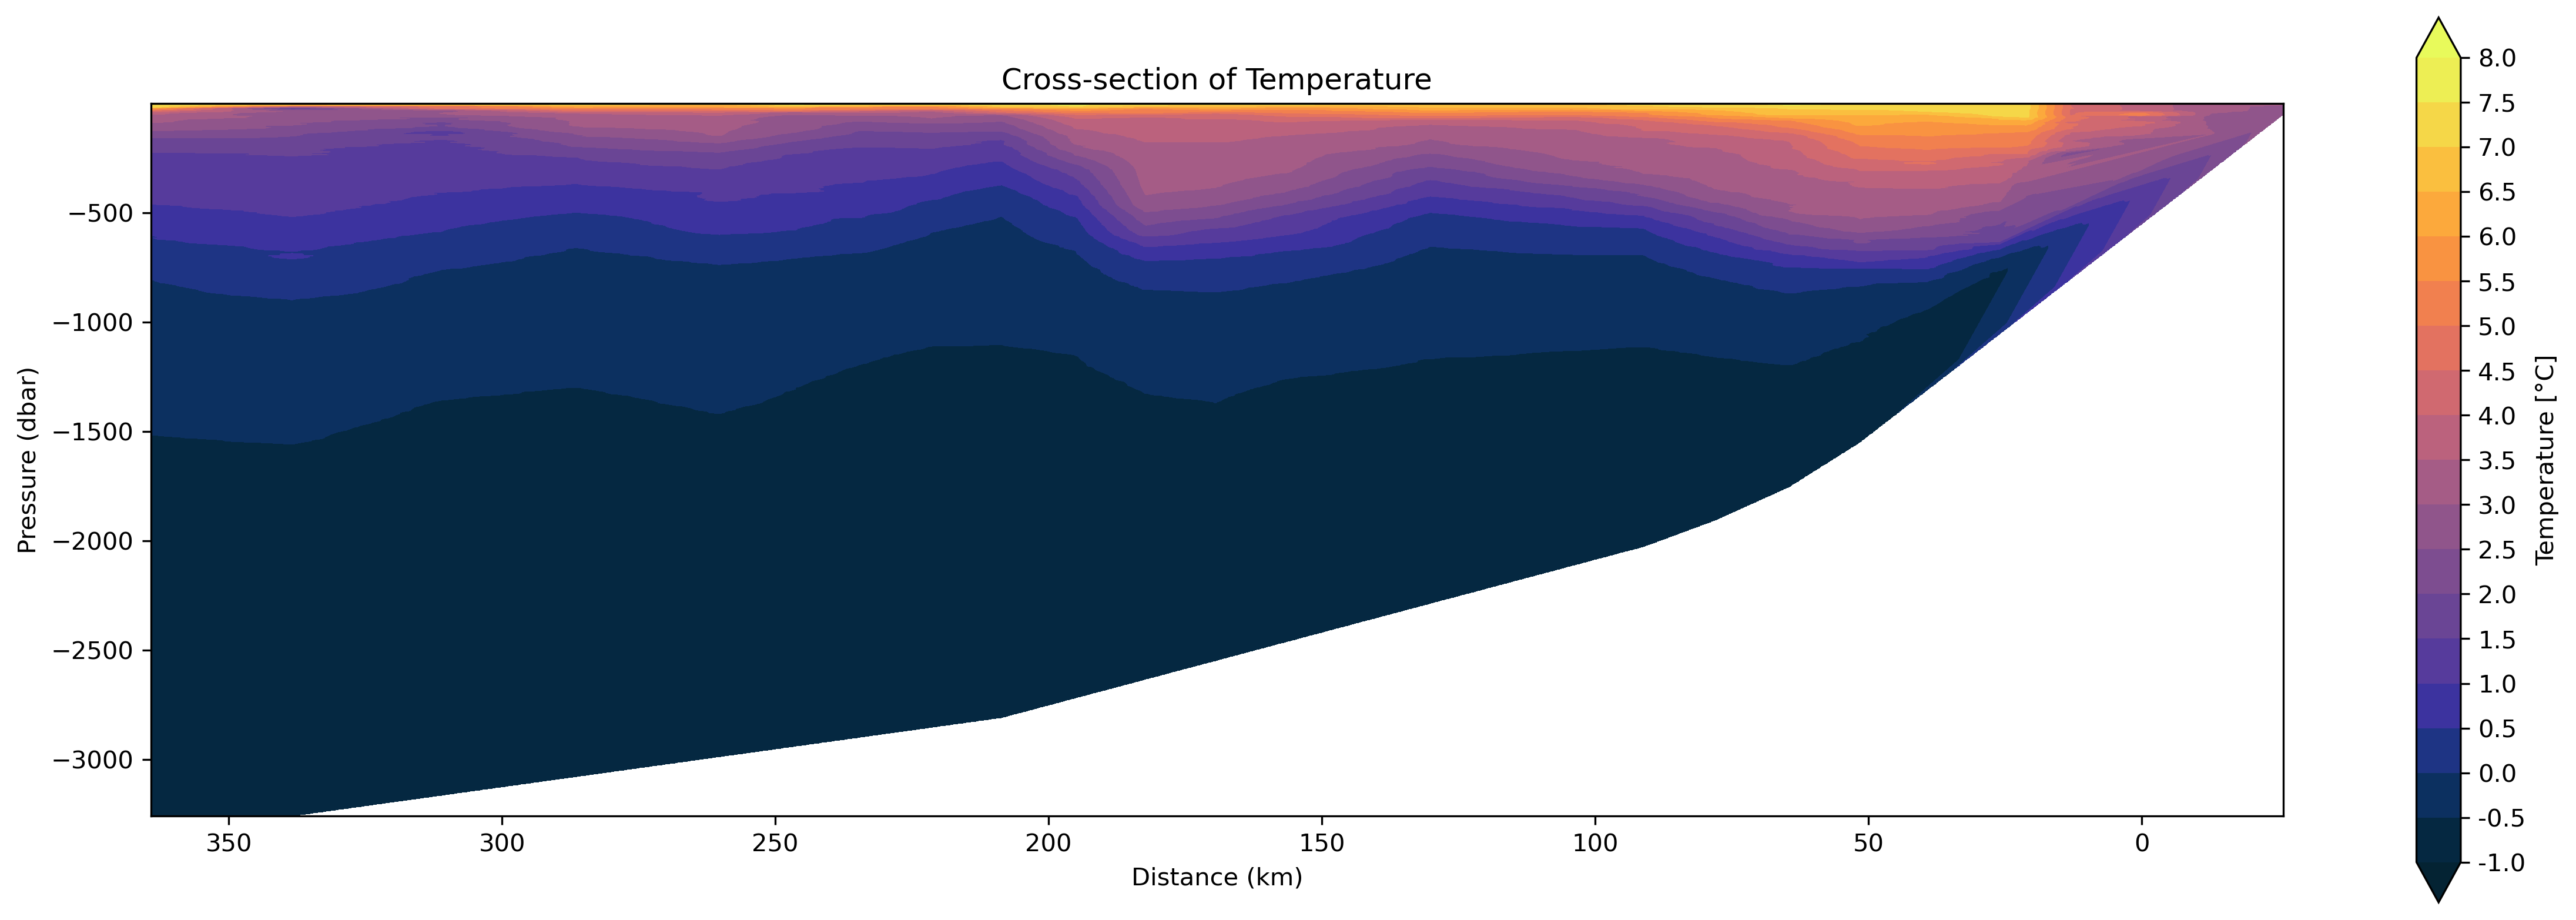

In [25]:
# Converting data to lists
x, y, z = [], [], []
grouped_stations = stations_N_sorted.groupby('station_name') # Grouping data by station_name -> each group contains data for a single measurement station


for station_id, group in grouped_stations:
    dist = group['distance_km'].iloc[0]  
    pres = group['pres'].iloc[0]  
    CT = group['CT'].iloc[0] 

    # Duplication of distance for each pressure measurement
    x.extend([dist] * len(pres))  
    y.extend(pres.tolist())  # pres.tolist -> conversion for list if numpy.ndarray
    z.extend(CT.tolist())    

# Conversion to numpy
x = np.array(x)
y = np.array(y)
z = np.array(z)

# Flattening y and z and adjusting x accordingly
y_cleaned = []
z_cleaned = []
x_cleaned = []

# Checking the length of x
x_length = len(x)


# Iterating through y to flatten and adjust x
for idx, pres_value in enumerate(y):
    if isinstance(pres_value, np.ndarray):  # Checking if it's an Numpy array
        pres_flat = pres_value.flatten()  # Flatten to 1D
        y_cleaned.extend(pres_flat)  # Adding all values to y_cleaned
        x_cleaned.extend([x[idx % x_length]] * len(pres_flat))  # Reapeating correspondng data for x -> x[idx % x_length] ensures that the index x do not exceed the available range (if x is shorter than y)
    else:
        y_cleaned.append(pres_value)
        x_cleaned.append(x[idx % x_length])

# Iterating through z to flatten (same process as for y)
for idx, temp_value in enumerate(z):
    if isinstance(temp_value, np.ndarray):
        temp_flat = temp_value.flatten()
        z_cleaned.extend(temp_flat)
    else:
        z_cleaned.append(temp_value)

# Checking if all lists (x_cleaned, y_cleaned, z_cleaned) have the same length
print(f"Length x_cleaned: {len(x_cleaned)}")
print(f"Length y_cleaned: {len(y_cleaned)}")
print(f"Length z_cleaned: {len(z_cleaned)}")

# Creating a DataFrame and removing missing data
valid_data = pd.DataFrame({'x': x_cleaned, 'y': y_cleaned, 'z': z_cleaned})
valid_data = valid_data.dropna() # removing NaN


# Conversion to numpy arrays
x_clean = valid_data['x'].values
y_clean = valid_data['y'].values
z_clean = valid_data['z'].values


# Creating a grid
xi = np.linspace(min(valid_data['x']), max(valid_data['x']), 2000)  # Creating 2000 evenly spaced points 
yi = np.linspace(min(valid_data['y']), max(valid_data['y']), 2000)
X, Y = np.meshgrid(xi, yi) # Creating two-dimensional matrices
Z = griddata((valid_data['x'], valid_data['y']), valid_data['z'], (X, Y), method='linear') # Interpolation of Z data on X, Y grid

# Setting contour levels based on the range of min and max of z_clean
min_temp = np.min(valid_data['z'])  
max_temp = np.max(valid_data['z'])  

# Definig levels with a step of 0.5°C
levels = np.arange(np.floor(min_temp), np.ceil(max_temp) + 0.5, 0.5)

# Constant scale conversion
scale_x = 0.05  # 1 km = 0.05 cm on diagram 
scale_y = 0.002  # 500 dbar = 1 cm

# Dynamic chart size based on the data range
fig_width = (max(valid_data['x']) - min(valid_data['x'])) * scale_x
fig_height = (max(valid_data['y']) - min(valid_data['y'])) * scale_y

# Creating a plot
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

# Colour map using cmocean's 'thermal' color map for temperature
cmap = cmocean.cm.thermal

# Creating contours every 0.5°C
contour = ax.contourf(-X, -Y, Z, levels=levels, cmap=cmap, extend='both')


# Adding a colorbar
cbar = plt.colorbar(contour)
cbar.set_label('Temperature [°C]')


# Setting values every  0.5°C on the color bar
cbar.set_ticks(np.arange(np.floor(np.min(z_clean)), np.ceil(np.max(z_clean)) + 0.5, 0.5))  # Values with a step of 0.5
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # One decimal place for better display

# Forcing scale proportions
ax.set_aspect(scale_y / scale_x)  # 10 km = constant number of pixles

# Axis labels and title
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Pressure (dbar)")
ax.set_title("Cross-section of Temperature")

# Inversion of x axis
ax.invert_xaxis()

plt.show()

Length x_cleaned: 98037
Length y_cleaned: 98037
Length z_cleaned: 98037


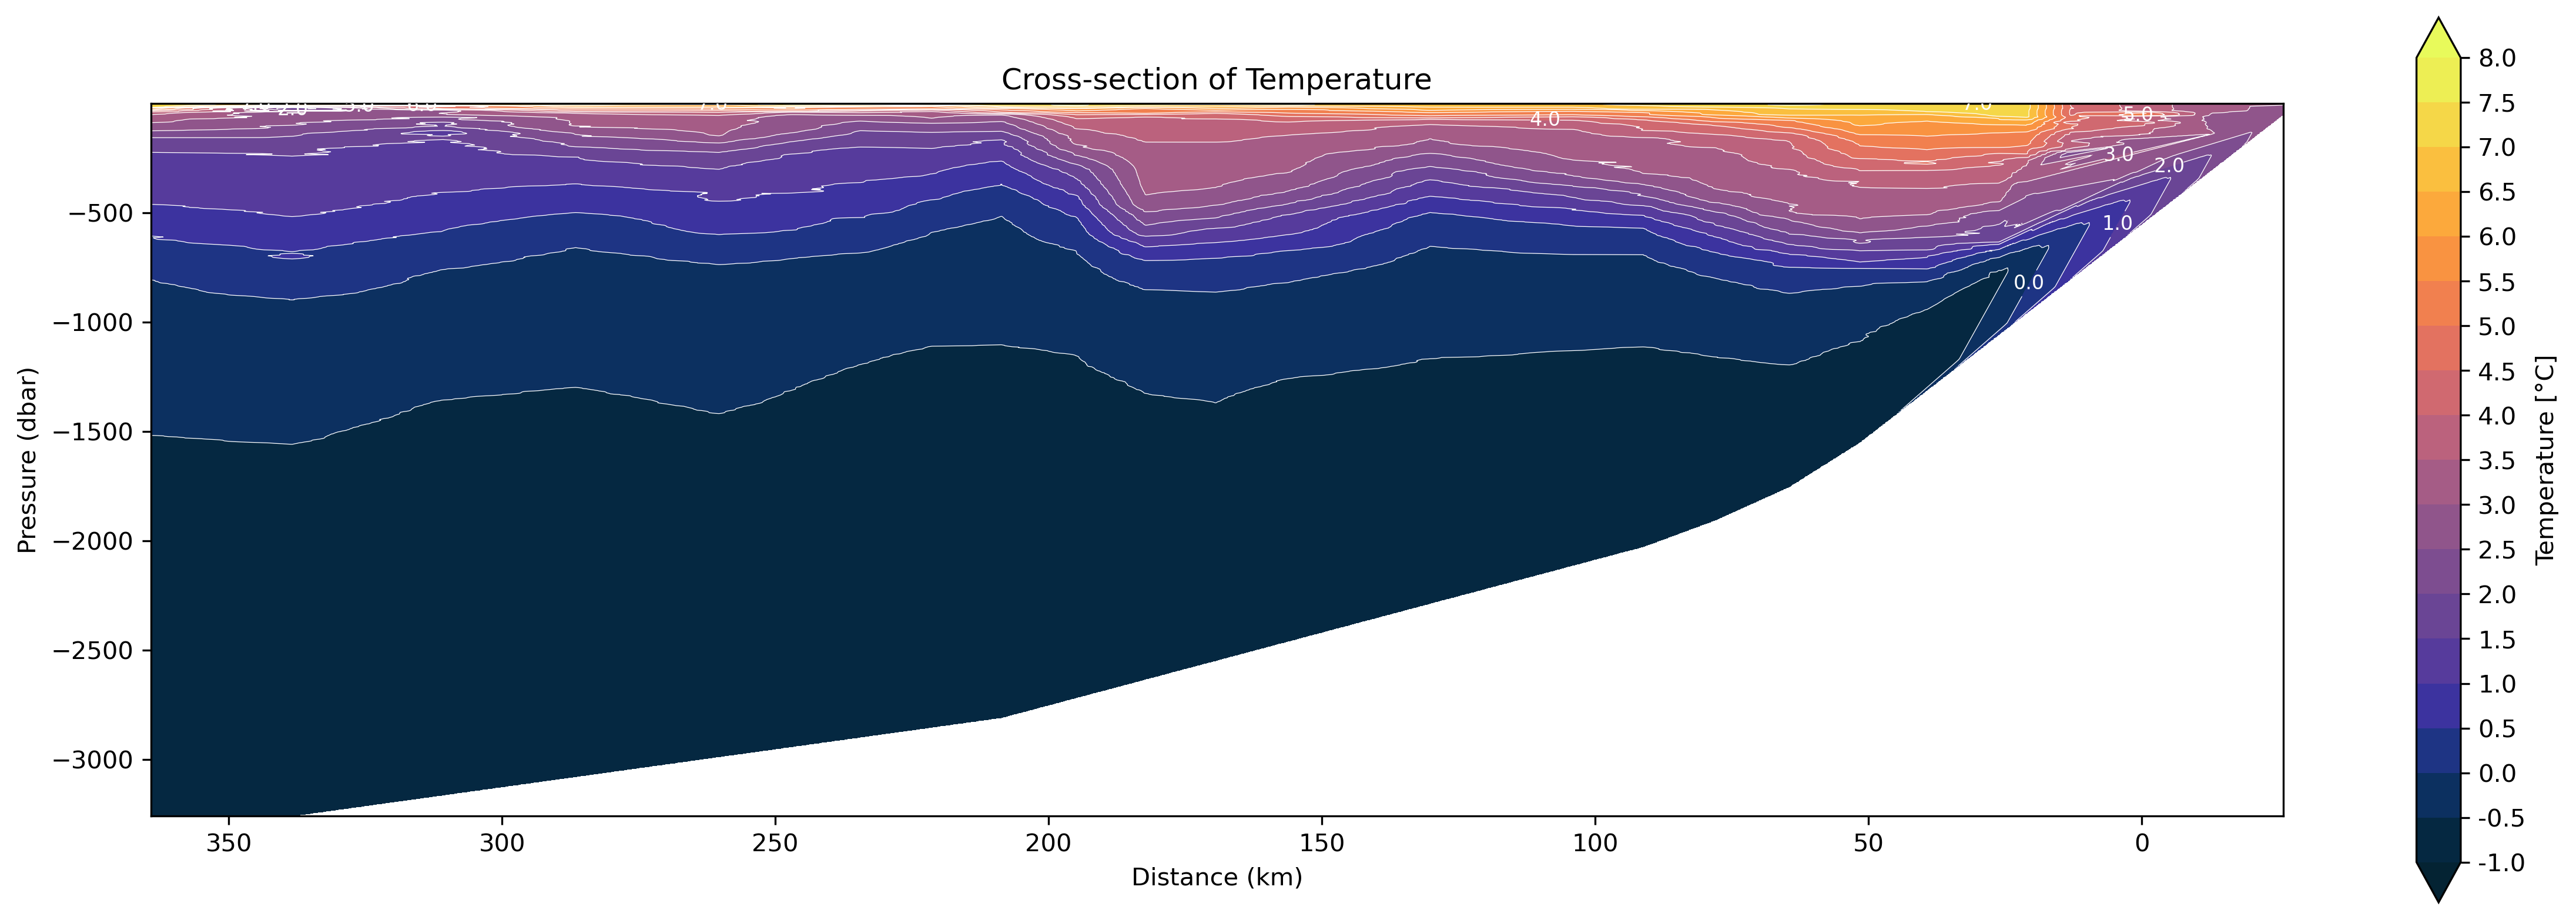

In [27]:
# Converting data to lists
x, y, z = [], [], []
grouped_stations = stations_N_sorted.groupby('station_name') # Grouping data by station_name -> each group contains data for a single measurement station


for station_id, group in grouped_stations:
    dist = group['distance_km'].iloc[0]  
    pres = group['pres'].iloc[0]  
    CT = group['CT'].iloc[0] 

    # Duplication of distance for each pressure measurement
    x.extend([dist] * len(pres))  
    y.extend(pres.tolist())  # pres.tolist -> conversion for list if numpy.ndarray
    z.extend(CT.tolist())    

# Conversion to numpy
x = np.array(x)
y = np.array(y)
z = np.array(z)

# Flattening y and z and adjusting x accordingly
y_cleaned = []
z_cleaned = []
x_cleaned = []

# Checking the length of x
x_length = len(x)


# Iterating through y to flatten and adjust x
for idx, pres_value in enumerate(y):
    if isinstance(pres_value, np.ndarray):  # Checking if it's an Numpy array
        pres_flat = pres_value.flatten()  # Flatten to 1D
        y_cleaned.extend(pres_flat)  # Adding all values to y_cleaned
        x_cleaned.extend([x[idx % x_length]] * len(pres_flat))  # Reapeating correspondng data for x -> x[idx % x_length] ensures that the index x do not exceed the available range (if x is shorter than y)
    else:
        y_cleaned.append(pres_value)
        x_cleaned.append(x[idx % x_length])
# Iterating through z to flatten (same process as for y)
for idx, temp_value in enumerate(z):
    if isinstance(temp_value, np.ndarray):
        temp_flat = temp_value.flatten()
        z_cleaned.extend(temp_flat)
    else:
        z_cleaned.append(temp_value)

# Checking if all lists (x_cleaned, y_cleaned, z_cleaned) have the same length
print(f"Length x_cleaned: {len(x_cleaned)}")
print(f"Length y_cleaned: {len(y_cleaned)}")
print(f"Length z_cleaned: {len(z_cleaned)}")

# Creating a DataFrame and removing missing data
valid_data = pd.DataFrame({'x': x_cleaned, 'y': y_cleaned, 'z': z_cleaned})
valid_data = valid_data.dropna() # removing NaN


# Conversion to numpy arrays
x_clean = valid_data['x'].values
y_clean = valid_data['y'].values
z_clean = valid_data['z'].values


# Creating a grid
xi = np.linspace(min(valid_data['x']), max(valid_data['x']), 2000)  # Creating 2000 evenly spaced points 
yi = np.linspace(min(valid_data['y']), max(valid_data['y']), 2000)
X, Y = np.meshgrid(xi, yi) # Creating two-dimensional matrices
Z = griddata((valid_data['x'], valid_data['y']), valid_data['z'], (X, Y), method='linear') # Interpolation of Z data on X, Y grid

# Setting contour levels based on the range of min and max of z_clean
min_temp = np.min(valid_data['z'])  
max_temp = np.max(valid_data['z'])  

# Definig levels with a step of 0.5°C
levels = np.arange(np.floor(min_temp), np.ceil(max_temp) + 0.5, 0.5)

# Constant scale conversion
scale_x = 0.05  # 1 km = 0.05 cm on diagram 
scale_y = 0.002  # 500 dbar = 1 cm

# Dynamic chart size based on the data range
fig_width = (max(valid_data['x']) - min(valid_data['x'])) * scale_x
fig_height = (max(valid_data['y']) - min(valid_data['y'])) * scale_y

# Creating a plot
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

# Colour map using cmocean's 'thermal' color map for temperature
cmap = cmocean.cm.thermal

# Creating contours every 0.5°C
contour = ax.contourf(-X, -Y, Z, levels=levels, cmap=cmap, extend='both')

# CONTOUR LINES ONLY UP TO 7°C
contour_lines = ax.contour(-X, -Y, Z, levels=levels, colors='white', linewidths=0.3, linestyles='solid')

# SELECTING CONTOUR LEVELS THAT ARE MULTIPLES OF 1°C
available_levels = contour_lines.levels  # Retrieving all the levels created by contour() 
label_levels = [lvl for lvl in available_levels if lvl % 1 == 0]  # Every 1°C

# ADDING LABELS ONLY FOR LEVELS EVERY 1°C
for text in ax.clabel(contour_lines, levels=label_levels, fmt='%1.1f', fontsize=8):
    text.set_rotation(0)  # 0° = horizontally 


# Adding a colorbar
cbar = plt.colorbar(contour)
cbar.set_label('Temperature [°C]')

# Setting values every  0.5°C on the color bar
cbar.set_ticks(np.arange(np.floor(np.min(z_clean)), np.ceil(np.max(z_clean)) + 0.5, 0.5))  # Values with a step of 0.5
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))  # One decimal place for better display

# Forcing scale proportions
ax.set_aspect(scale_y / scale_x)  # 10 km = constant number of pixles

# Axis labels and title
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Pressure (dbar)")
ax.set_title("Cross-section of Temperature")

# Inversion of x axis
ax.invert_xaxis()

plt.show()

In [54]:
# Determining the distance range- 0-180 km
mask_x = (x_clean >= 0) & (x_clean <= 180)

# Creating a mask for temp above 0°C
mask_temp = np.where(z_clean > 0, 1, np.nan) # 1 for temp above 0°C, NaN for others 

# Applying a mask to temp values
temp_filtered = z_clean[mask_x] * mask_temp[mask_x]

# Calculating the averege
mean_temp = np.nanmean(temp_filtered) # -> np.nanmean() works as np.mean() but igores NaN

print(f"Averege temperature in the range of 0-180 km for values > 0°C: {mean_temp:.2f}°C")






Averege temperature in the range of 0-180 km for values > 0°C: 3.35°C
